In [26]:
# Importing Libraries
import pandas as pd
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading global stock price data for exxon mobil
global_stock_exxon = pd.read_csv('final_global_stock_price_for_exxon.csv',index_col='Date',parse_dates=True)
global_stock_exxon.sort_index(inplace = True)
global_stock_exxon_start_date = global_stock_exxon.index[0]
global_stock_exxon_end_date = global_stock_exxon.index[-1]

## NEWS SENTIMENTS DATA PREPARATION FOR TRAINING WITH STOCK PRICE VALUE

In [3]:
# Loading the News Sentiments Data and retrieving the segment of use
news_sentiments = pd.read_csv('new_daily_news.csv',index_col='Date',parse_dates=True)
news_sentiments.sort_index(inplace = True)
news_sentiments.drop(news_sentiments.filter(regex="Unname"),axis=1, inplace=True)
news_sentiments_segment = news_sentiments[global_stock_exxon_start_date:global_stock_exxon_end_date]
news_sentiments_segment_start_date = news_sentiments_segment.index[0]
news_sentiments_segment_end_date = news_sentiments_segment.index[-1]

In [4]:
# Handling the NaN values present in the data
for i in news_sentiments_segment.index:
    if news_sentiments_segment['News Present'][i] == 0:
        news_sentiments_segment['Daily News Sentiment'][i] = 0

In [5]:
# Creating the segment of stock data such that both the data are in same timeframe 
stock_data_exxon_segment = global_stock_exxon[news_sentiments_segment_start_date:news_sentiments_segment_end_date]

In [6]:
# Creating final data that is used for training the model which gives the impact of News Sentiments Data on Stock Price Value
combined_column_list = []
for i in news_sentiments_segment.columns:
    combined_column_list.append(i)
for i in stock_data_exxon_segment.columns:
    combined_column_list.append(i)

In [7]:
# Creating Joint data of News Sentiments and Stock Price Value
sentiments_vs_stock_exxon_data = pd.DataFrame()
for i in combined_column_list:
    if i == 'Value':
        sentiments_vs_stock_exxon_data[i] = stock_data_exxon_segment['Value']        
    elif i == 'Data Present':
        sentiments_vs_stock_exxon_data[i] = stock_data_exxon_segment['Data Present']
    else:
        sentiments_vs_stock_exxon_data[i] = news_sentiments_segment[i]

In [8]:
# Function for Spliting the data into Training-Validation-Testing Data with split ratio as 80-10-10

def train_valid_test_split(dataset):
    tr_size=int((dataset.shape[0])*0.8)
    va_size=int((dataset.shape[0])*0.9)
    train = dataset[:tr_size]
    validation = dataset[tr_size:va_size]
    test = dataset[va_size:]
    return train,validation,test

In [9]:
# Spliting the data into Training-Validation-Testing Data with split ratio as 80-10-10
train, validation, test = train_valid_test_split(sentiments_vs_stock_exxon_data)

In [10]:
# Getting the trainable features and label from the actual data

# Training Set
train_X = train.drop(columns=['Value'])
train_y = train['Value']

# Validation Set
validation_X = validation.drop(columns=['Value'])
validation_y = validation['Value']

# Testing Set
test_X = test.drop(columns=['Value'])
test_y = test['Value']

## Training LinearRegression Model to get linear impact of News Sentiments on Stock Price of Exxon

In [11]:
# Importing LinearRegression Model from sklearn
from sklearn.linear_model import LinearRegression

In [12]:
# Creating and Fitting the linear model on Training Set of the data
linear_model = LinearRegression()
linear_model.fit(train_X,train_y)

LinearRegression()

In [13]:
# Predicting the stock price value for exxon using linear model
pred_train_y = linear_model.predict(train_X)
pred_valid_y = linear_model.predict(validation_X)
pred_test_y = linear_model.predict(test_X)

In [14]:
# Using Root Mean Squared Error Metrics for Model Evaluation
from sklearn.metrics import mean_squared_error

rmse_train = np.sqrt(mean_squared_error(train_y,pred_train_y))
rmse_valid = np.sqrt(mean_squared_error(validation_y,pred_valid_y))
rmse_test = np.sqrt(mean_squared_error(test_y,pred_test_y))

rmse_train,rmse_valid,rmse_test

(10.508487089215382, 32.46389003639849, 31.916050452189424)

In [15]:
#Creating the target vs prediction dataframe for each set of data for linear model

train_result = pd.DataFrame()
train_result['target'] = train_y
train_result['predicted']=pred_train_y
train_result.to_csv('linear_model_train_result.csv')

validation_result = pd.DataFrame()
validation_result['target'] = validation_y
validation_result['predicted']=pred_valid_y
validation_result.to_csv('linear_model_validation_result.csv')

test_result = pd.DataFrame()
test_result['target'] = test_y
test_result['predicted']=pred_test_y
test_result.to_csv('linear_model_test_result.csv')

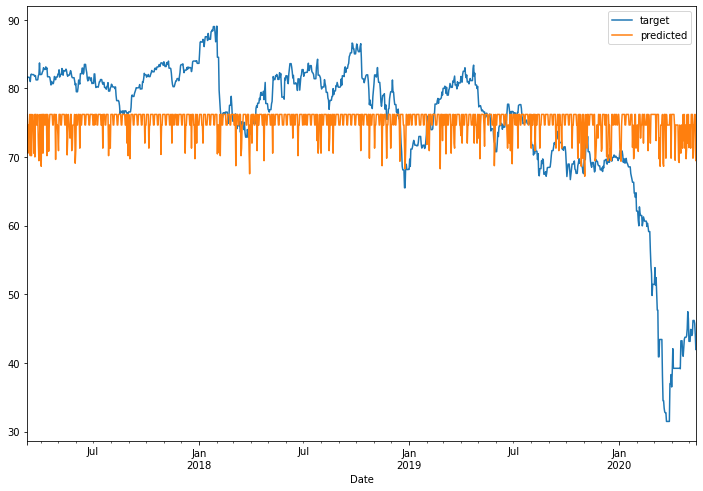

In [16]:
# Plotting the fit of prediction to the target of training data for linear model
train_result[['target','predicted']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

## Getting the feature importance of News Sentiments Data using Permutation_Importance by Sklearn for Linear Model

In [17]:
from sklearn.inspection import permutation_importance

In [18]:
# Knowing the importance of each feature of News Sentiments Data for linear model

linear = permutation_importance(linear_model,train_X, train_y,n_repeats=30,random_state=43)
for i in linear.importances_mean.argsort()[::-1]:
    if linear.importances_mean[i] - 2 * linear.importances_std[i] > 0:
        print(f"{combined_column_list[i]:<8}"
              f"{linear.importances_mean[i]:.3f}"
              f" +/- {linear.importances_std[i]:.3f}")

News Present0.043 +/- 0.009
Value   0.009 +/- 0.004


## Training RandomForestRegressor Model to get non-linear impact of News Sentiments on Stock Price of Exxon

In [19]:
# Importing RandomForestRegressor Model from sklearn
from sklearn.ensemble import RandomForestRegressor

In [20]:
# Creating and Fitting the random forest model on Training Set of the data
rf_model = RandomForestRegressor()
rf_model.fit(train_X,train_y)

RandomForestRegressor()

In [21]:
# Predicting the stock price value for exxon using random forest model
pred_train_y_rf = rf_model.predict(train_X)
pred_valid_y_rf = rf_model.predict(validation_X)
pred_test_y_rf = rf_model.predict(test_X)

In [22]:
# Using Root Mean Squared Error Metrics for Model Evaluation

rmse_train_rf = np.sqrt(mean_squared_error(train_y,pred_train_y_rf))
rmse_valid_rf = np.sqrt(mean_squared_error(validation_y,pred_valid_y_rf))
rmse_test_rf = np.sqrt(mean_squared_error(test_y,pred_test_y_rf))

rmse_train_rf,rmse_valid_rf,rmse_test_rf

(10.165286913289574, 32.918318656576176, 32.33043475634553)

In [23]:
#Creating the target vs prediction dataframe for each set of data for random forest model

train_result_rf = pd.DataFrame()
train_result_rf['target'] = train_y
train_result_rf['predicted']=pred_train_y_rf
train_result_rf.to_csv('random_forest_model_train_result.csv')

validation_result_rf = pd.DataFrame()
validation_result_rf['target'] = validation_y
validation_result_rf['predicted']=pred_valid_y_rf
validation_result_rf.to_csv('random_forest_model_validation_result.csv')

test_result_rf = pd.DataFrame()
test_result_rf['target'] = test_y
test_result_rf['predicted']=pred_test_y_rf
test_result_rf.to_csv('random_forest_model_test_result.csv')

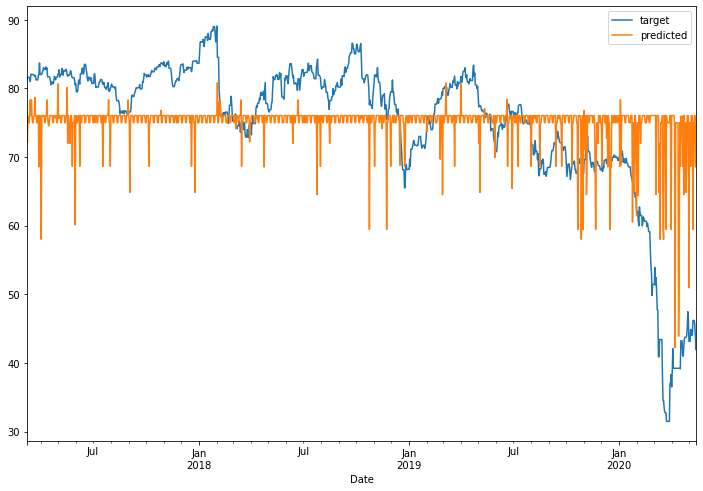

In [24]:
# Plotting the fit of prediction to the target of training data for random forest model
train_result_rf[['target','predicted']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

## Getting the feature importance of News Sentiments Data using Permutation_Importance by Sklearn for Linear Model

In [25]:
# Knowing the importance of each feature of News Sentiments Data for random forest model

rf = permutation_importance(rf_model,train_X, train_y,n_repeats=30,random_state=43)
for i in rf.importances_mean.argsort()[::-1]:
    if rf.importances_mean[i] - 2 * rf.importances_std[i] > 0:
        print(f"{combined_column_list[i]:<8}"
              f"{rf.importances_mean[i]:.3f}"
              f" +/- {rf.importances_std[i]:.3f}")

Daily News Sentiment0.113 +/- 0.014
Value   0.058 +/- 0.014
News Present0.042 +/- 0.009
